In [6]:
import tensorflow as tf ### Models
import matplotlib.pyplot as plt ### Plotting Bar Chart
import numpy as np ### Maths Computations
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten,GlobalAveragePooling2D, InputLayer, BatchNormalization, Input, Layer, Resizing, Rescaling, Embedding, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.regularizers import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import albumentations as A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/Dataset.rar", outdir="/content/dataset/")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.4 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/Dataset.rar ...
INFO:patool:Extracting /content/drive/MyDrive/Dataset.rar ...
INFO patool: ... creating output directory `/content/dataset/'.
INFO:patool:... creating output directory `/content/dataset/'.
INFO patool: running /usr/bin/unrar x -- /content/drive/MyDrive/Dataset.rar
INFO:patool:running /usr/bin/unrar x -- /content/drive/MyDrive/Dataset.rar
INFO patool:     with cwd='/content/dataset/', input=''
INFO:patool:    with cwd='/content/dataset/', input=''
INFO patool: ... /content/drive/MyDrive/Dataset.rar extracted to `/content/dataset/'.
INFO:patool:... /content/drive/MyDrive/Dataset.rar extracted to `/content/dataset/'.


'/content/dataset/'

In [14]:
train_directory = "/content/dataset/Dataset/Train Set"
validation_directory = "/content/dataset/Dataset/Test Set"
CLASS_NAMES = ["Human", "Animal"]
CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
    "LEARNING_RATE" : 0.001,
    "N_EPOCHS" : 100,
    "DROPOUT_RATE" : 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 100,
    "N_DENSE_2" : 10,
    "NUM_CLASSES" :2,
    }

In [16]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    shuffle = True,
    seed = 99,
)


NotFoundError: Could not find directory /content/dataset/Dataset/Train Set

In [5]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    shuffle = True,
    seed = 99,
)

Found 5020 files belonging to 2 classes.


In [6]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[119.5       ,  99.5       ,  75.        ],
         [124.375     , 112.875     ,  78.375     ],
         [141.        , 126.        ,  99.75      ],
         ...,
         [178.625     , 165.625     , 146.625     ],
         [154.125     , 147.625     , 118.875     ],
         [142.375     , 131.5       , 103.75      ]],

        [[ 99.        ,  82.875     ,  56.875     ],
         [109.5       ,  89.875     ,  61.75      ],
         [117.5       , 100.5       ,  70.5       ],
         ...,
         [153.25      , 145.5       , 122.375     ],
         [135.        , 121.        ,  94.5       ],
         [119.625     , 105.125     ,  80.625     ]],

        [[ 95.5       ,  83.5       ,  61.125     ],
         [ 98.875     ,  83.375     ,  62.        ],
         [106.125     ,  91.625     ,  65.625     ],
         ...,
         [132.625     , 125.625     , 101.125     ],
         [111.625     ,  95.625     ,  70.125 

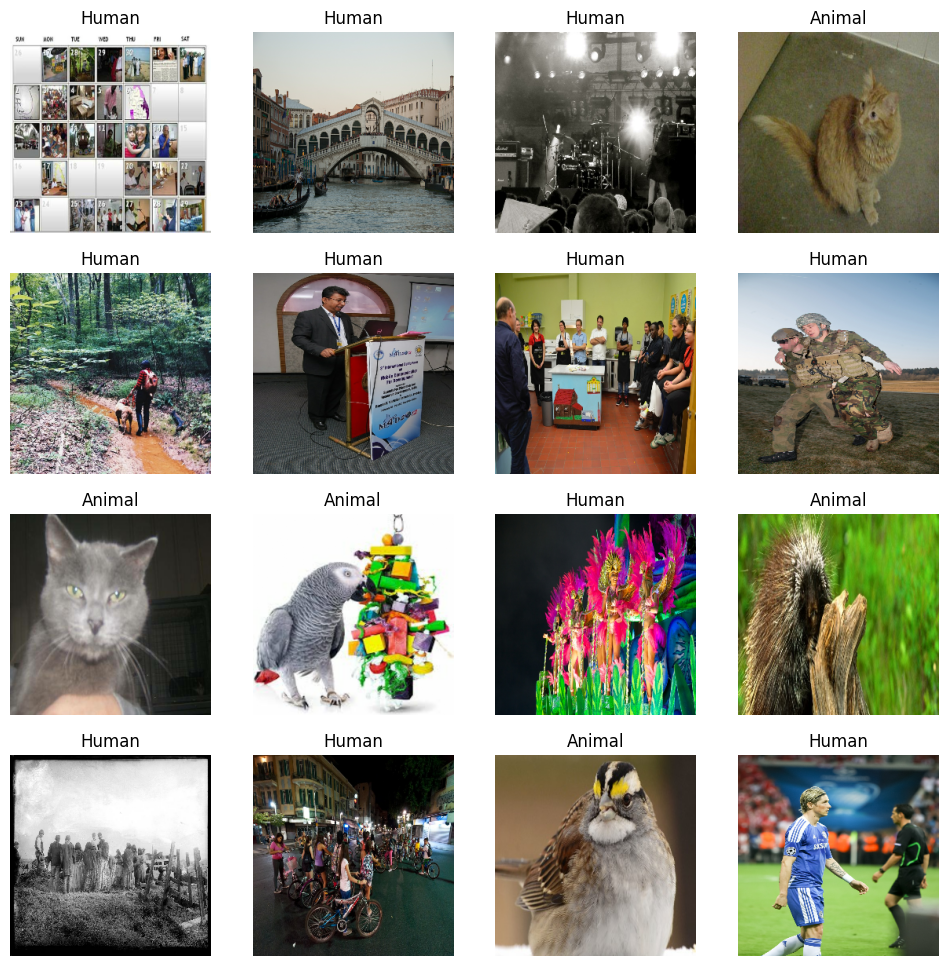

In [7]:
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [8]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
Validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

In [12]:
Model1 = tf.keras.Sequential([
    InputLayer(input_shape = (None,None,3)),
    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION['N_FILTERS'], kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], padding = 'valid', activation = 'relu',  kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES'] *2),

    Conv2D(filters = CONFIGURATION['N_FILTERS']*2+4, kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], padding = 'valid', activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu'),
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu'),
    BatchNormalization(),
    Dense(CONFIGURATION["NUM_CLASSES"], activation = 'sigmoid')
])
Model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 16)     

In [13]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {}".format(epoch+1, logs["loss"]))
  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of{}".format(batch+1, logs))

In [14]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=False
)

In [15]:
es_callback = EarlyStopping(
    monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1,
    mode = 'auto', baseline = None, restore_best_weights = False
)

In [16]:
def scheduler(epoch, lr):
  if epoch <= 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

In [17]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.tf',
    monitor = 'val_loss',
    save_best_only = True,
)

In [18]:
Plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,

)

In [19]:
metrics = [TruePositives(name ='tp'),FalsePositives(name ='fp'),
          BinaryAccuracy(name ='accuracy'),Precision(name ='precision'),Recall(name ='recall'),AUC(name = 'auc')]

In [20]:
Model1.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = metrics)

In [21]:
history=Model1.fit(
    training_dataset,
    validation_data = Validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks = ([checkpoint_callback], [scheduler_callback],[Plateau_callback],[es_callback],[csv_callback], [LossCallback()])
)

Streaming output truncated to the last 5000 lines.
531/755 [====================>.........] - ETA: 55s - loss: 0.0536 - tp: 16670.0000 - fp: 325.0000 - accuracy: 0.9810 - precision: 0.9809 - recall: 0.9810 - auc: 0.9977
 For Batch Number 532 the model has a loss of{'loss': 0.05355066806077957, 'tp': 16701.0, 'fp': 325.0, 'accuracy': 0.9809680581092834, 'precision': 0.9809115529060364, 'recall': 0.9810267686843872, 'auc': 0.997743546962738}
532/755 [====================>.........] - ETA: 55s - loss: 0.0536 - tp: 16701.0000 - fp: 325.0000 - accuracy: 0.9810 - precision: 0.9809 - recall: 0.9810 - auc: 0.9977
 For Batch Number 533 the model has a loss of{'loss': 0.053458716720342636, 'tp': 16733.0, 'fp': 325.0, 'accuracy': 0.9810037612915039, 'precision': 0.9809473752975464, 'recall': 0.9810624122619629, 'auc': 0.9977505207061768}
533/755 [====================>.........] - ETA: 54s - loss: 0.0535 - tp: 16733.0000 - fp: 325.0000 - accuracy: 0.9810 - precision: 0.9809 - recall: 0.9811 - auc:

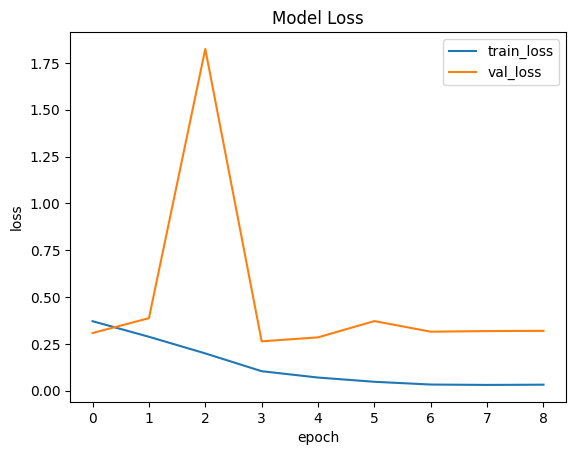

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

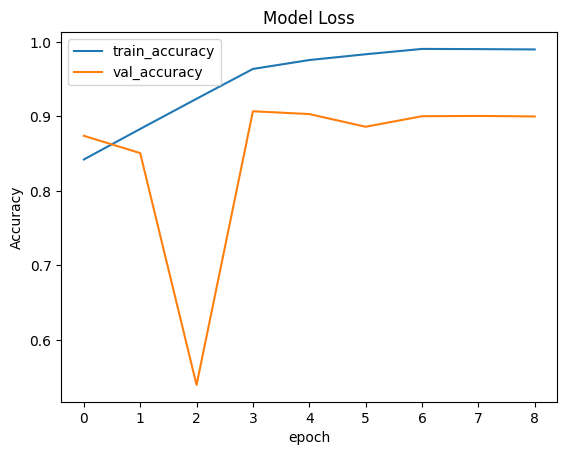

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show

In [4]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/Saved.zip", outdir="/content/Saved_Model/")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 1.6 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/Saved.zip ...
INFO:patool:Extracting /content/drive/MyDrive/Saved.zip ...
INFO patool: ... creating output directory `/content/Saved_Model/'.
INFO:patool:... creating output directory `/content/Saved_Model/'.
INFO patool: running /usr/bin/7z x -o/content/Saved_Model/ -- /content/drive/MyDrive/Saved.zip
INFO:patool:running /usr/bin/7z x -o/content/Saved_Model/ -- /content/drive/MyDrive/Saved.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/drive/MyDrive/Saved.zip extracted to `/content/Saved_Model/'.
INFO:patool:... /content/drive/MyDrive/Saved.zip extracted to `/content/Saved_Model/'.


'/content/Saved_Model/'

In [8]:
savedModel=load_model('/content/Saved_Model/content/weights.04-0.26.tf')
savedModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 16)     

Human


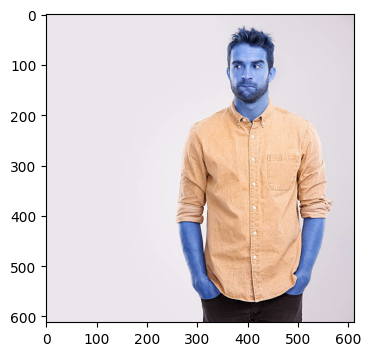

In [30]:
test_image = cv2.imread("/content/istockphoto-520131331-612x612.jpg")
#test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize = (4, 4))
plt.imshow(test_image)

test_image = tf.cast(test_image, tf.float32)
im = tf.expand_dims(test_image, axis = 0)
print(CLASS_NAMES[tf.argmax(savedModel(im), axis = -1).numpy()[0]])

Animal


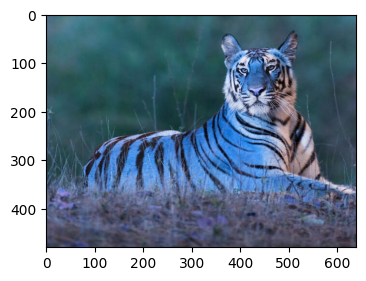

In [19]:
test_image = cv2.imread("/content/6aofsvaglm_Medium_WW226365.jpg")
#test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize = (4, 4))
plt.imshow(test_image)

test_image = tf.cast(test_image, tf.float32)
im = tf.expand_dims(test_image, axis = 0)
print(CLASS_NAMES[tf.argmax(savedModel(im), axis = -1).numpy()[0]])

Animal


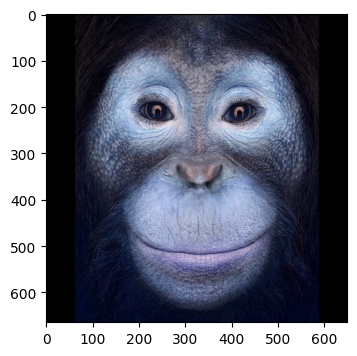

In [26]:
test_image = cv2.imread("/content/animal-photography-affinity-Brad-Wilson-orangutan-1.jpg")
#test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize = (4, 4))
plt.imshow(test_image)

test_image = tf.cast(test_image, tf.float32)
im = tf.expand_dims(test_image, axis = 0)
print(CLASS_NAMES[tf.argmax(savedModel(im), axis = -1).numpy()[0]])

Human


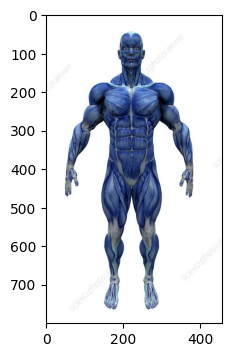

In [24]:
test_image = cv2.imread("/content/P1500165.jpg")
#test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize = (4, 4))
plt.imshow(test_image)

test_image = tf.cast(test_image, tf.float32)
im = tf.expand_dims(test_image, axis = 0)
print(CLASS_NAMES[tf.argmax(savedModel(im), axis = -1).numpy()[0]])

In [37]:
!zip -r Saved Model.zip /content/weights.04-0.26.tf

	zip warning: name not matched: Model.zip
  adding: content/weights.04-0.26.tf/ (stored 0%)
  adding: content/weights.04-0.26.tf/variables/ (stored 0%)
  adding: content/weights.04-0.26.tf/variables/variables.index (deflated 71%)
  adding: content/weights.04-0.26.tf/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/weights.04-0.26.tf/keras_metadata.pb (deflated 92%)
  adding: content/weights.04-0.26.tf/saved_model.pb (deflated 88%)
  adding: content/weights.04-0.26.tf/fingerprint.pb (stored 0%)
  adding: content/weights.04-0.26.tf/assets/ (stored 0%)
